# Анализ данных осень 2021
# Практический анализ данных и ML соревнования

#### Данные

In [282]:
!tree data/raw

data/raw
├── ads.csv
├── history.csv
├── sample_solution.csv
├── target.csv
└── users.csv

0 directories, 5 files


`users.tsv` - данные об аудитории == пользователях соцсети:
- `user_id`, `sex`, `age`, `city_id`

`history.tsv` - данные о рекламных компаниях:
- `hour` – в какой час пользователь видел объявление
- `cpm` - цена показанного рекламного объявления в рекламном аукционе. Это значит, что на данном аукционе это была максимальная ставка. 
- `publisher` - площадка, на который пользователь видел рекламу
- `user_id`

`validate_answers.tsv` - данные об охвате аудитории рекламной компании:
- `at_least_one` - доля пользователей, которая увидит объявление **хотя бы 1 раз**
- `at_least_two` - доля пользователей, которая увидит объявление **хотя бы 2 раза**
- `at_least_three` - доля пользователей, которая увидит объявление **хотя бы 3 раза**

### Разберёмся в данных

In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 3]

#### О пользователях

In [353]:
users = pd.read_csv('data/raw/users.csv')
print(f'dataset shape: {users.shape}')
users.head(7)

dataset shape: (27769, 4)


,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4
5,5,2,22,5
6,6,1,21,6


<AxesSubplot:>

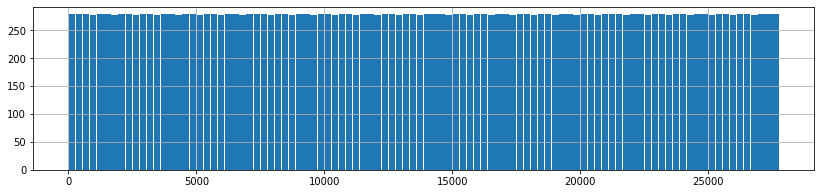

In [354]:
# Пользователи с какими id есть в данных?

users.user_id.hist(bins=100, rwidth=0.9)

<AxesSubplot:>

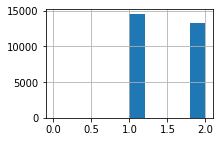

In [355]:
# Пол пользователей

users.sex.hist(figsize=(3, 2))

<AxesSubplot:>

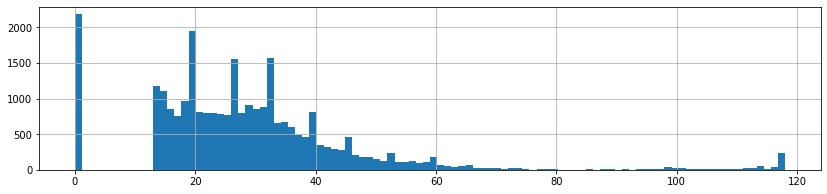

In [356]:
# Возраст

users.age.hist(bins=100)

<AxesSubplot:>

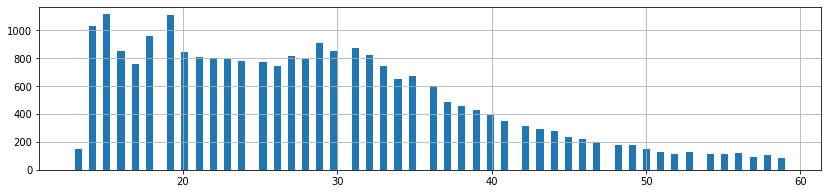

In [357]:
# Возраст основной аудитории

users[(users.age > 0) & (users.age < 60)].age.hist(bins=100)

Количество городов: 2457


<AxesSubplot:>

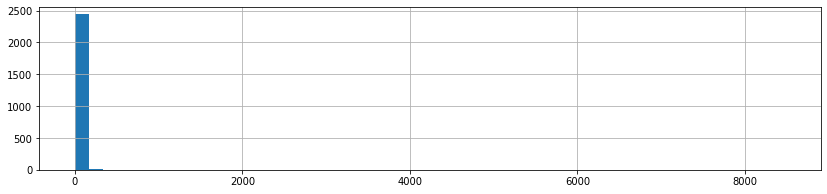

In [358]:
# Города пользователей

print(f'Количество городов: {len(users.city_id.unique())}')
# Сколько пользователей в каждом городе
vc = users.value_counts('city_id')
vc.hist(bins=50)

<AxesSubplot:>

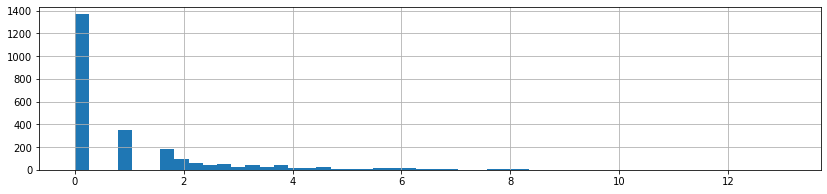

In [359]:
# Логарифмированное количество жителей городов
log2_vc = np.log2(vc)
log2_vc.hist(bins=50)

##### Менее тривиальные графики

<AxesSubplot:>

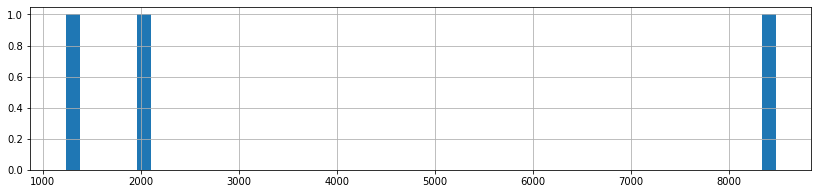

In [360]:
# Города с населением более 1к
vc[vc > 1000].hist(bins=50)

In [361]:
# Исследуем жителей больших городов
vc[vc > 1000]

city_id
0    8479
3    1985
7    1232
dtype: int64

In [362]:
cities_users = users[users.city_id.isin([0, 3, 7])]
cities_users.shape

(11696, 4)

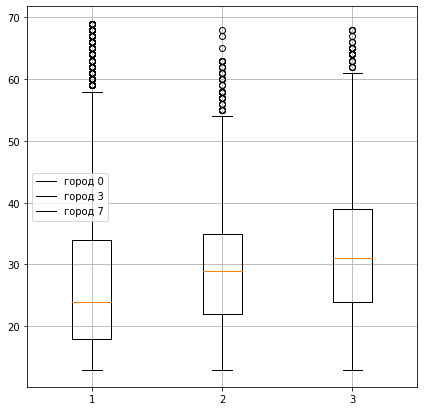

In [363]:
# Их возраст по городам

city_ages = cities_users[(cities_users.age > 0) & (cities_users.age < 70)].groupby('city_id').age.apply(list)

plt.figure(figsize=(7, 7))
plt.boxplot(city_ages)
plt.grid(True)
plt.legend([f'город {city_id}' for city_id in city_ages.index])
plt.show()

#### О рекламных компаниях

In [364]:
history = pd.read_csv('data/raw/history.csv')
print(history.shape)
history.head(7)

(1147857, 4)


,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
5,5,70.00,2,16334
6,10,73.22,1,25931


<AxesSubplot:>

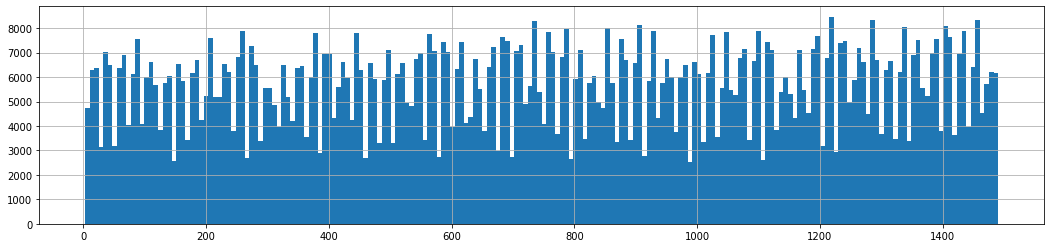

In [365]:
# Время объявлений в ходе всего периода сбора данных
history.hour.hist(bins=200, figsize=(18, 4))

<AxesSubplot:>

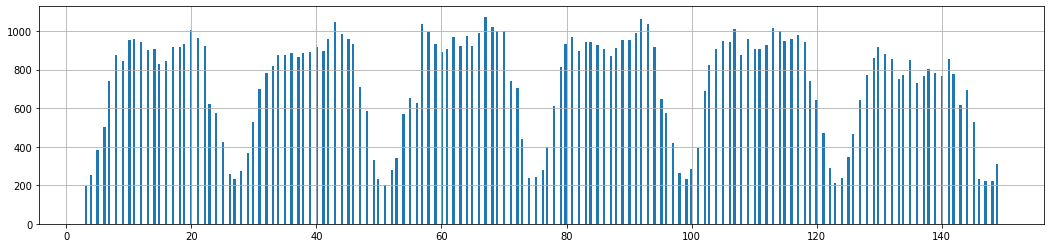

In [366]:
# Подробнее
history[history.hour < 150].hour.hist(bins=400, figsize=(18, 4))

<AxesSubplot:>

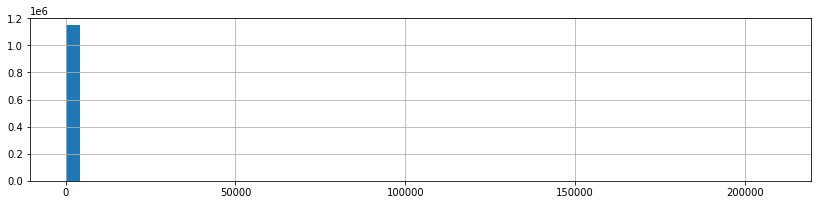

In [367]:
# Цены объявлений
history.cpm.hist(bins=50)

<AxesSubplot:>

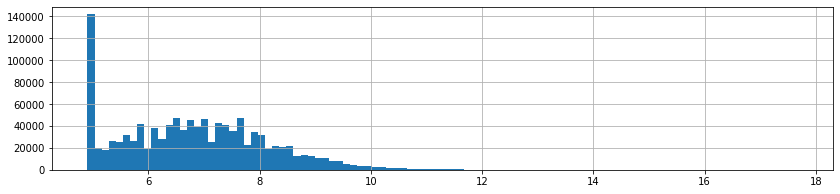

In [368]:
# Логарифмированные
cpms = history.cpm.apply(np.log2)
cpms.hist(bins=100)

<AxesSubplot:>

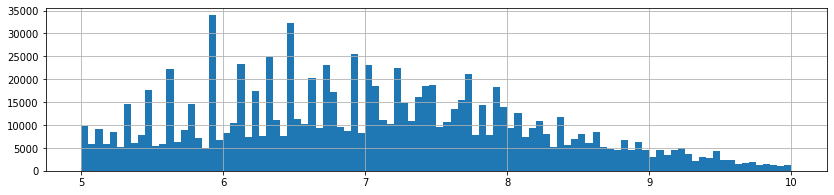

In [369]:
# Подробнее 
cpms[(cpms > 5) & (cpms < 10)].hist(bins=100)

21


Text(0, 0.5, 'Количество таких платформ')

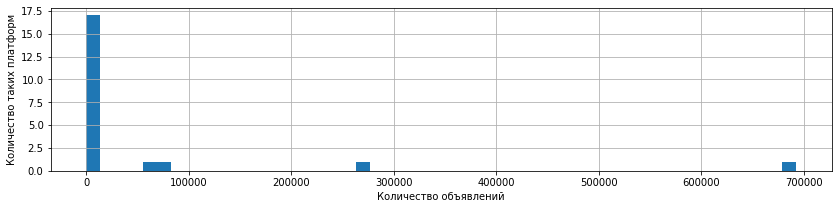

In [370]:
# Что за платформы для рекламы? Сколько их?

print(len(history.publisher.unique()))
vc = history.publisher.value_counts()
vc.hist(bins=50)
plt.xlabel('Количество объявлений')
plt.ylabel('Количество таких платформ')

Text(0, 0.5, 'Количество платформ')

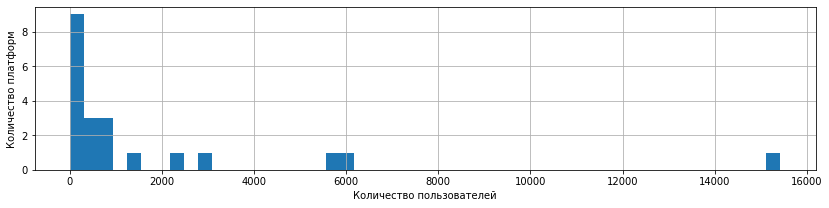

In [371]:
# Сколько уникальных пользователей на платформах?

history.groupby('publisher').user_id.apply(lambda users: len(set(users))).hist(bins=50)
plt.xlabel('Количество пользователей')
plt.ylabel('Количество платформ')

In [372]:
# Какой трафик на каждой платформе?

# Посчитаем для каждого часа: сколько постов было на каждой платформе?

n_publishers = len(history.publisher.unique())
posts_per_hour_by_publishers = []
TAKE_FIRST_N_HOURS = 24 * 4

for hour, hour_data in history[history.hour < TAKE_FIRST_N_HOURS].groupby('hour'):
    publishers_posts = hour_data.value_counts('publisher')
    
    counts = [0 for _ in range(n_publishers)]
    for pub_id, posts_n in list(publishers_posts.items()):
        counts[pub_id-1] = posts_n
        
    posts_per_hour_by_publishers.append([hour] + counts)

    
df = pd.DataFrame.from_records(posts_per_hour_by_publishers, columns=['hour'] + list(history.publisher.unique()))
df.head()

,hour,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,21,20
0,3,100,67,11,1,3,1,7,0,2,...,0,0,0,0,2,1,0,0,0,0
1,4,173,51,10,0,1,1,11,1,2,...,1,0,0,0,1,0,0,0,0,0
2,5,246,91,21,1,1,4,12,3,2,...,2,1,0,0,0,0,0,0,0,0
3,6,346,95,27,2,0,5,16,1,4,...,0,0,0,0,1,1,0,0,0,0
4,7,488,157,29,2,5,5,42,3,6,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Количество постов')

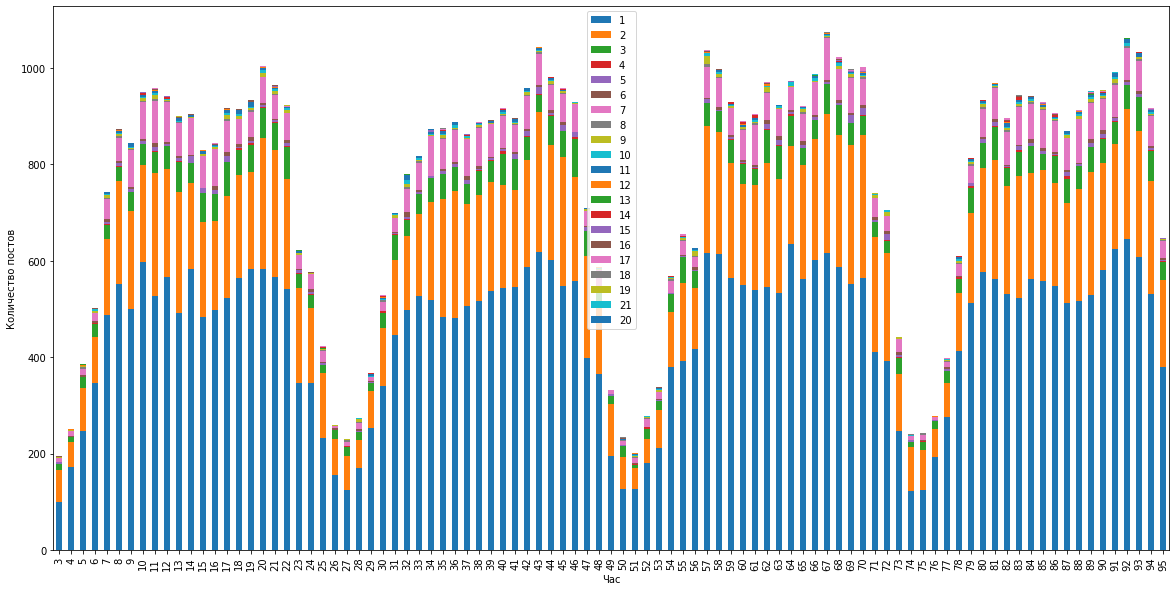

In [373]:
df.plot.bar(x='hour', stacked=True, figsize=(20, 10))
plt.xlabel('Час')
plt.ylabel('Количество постов')

<AxesSubplot:>

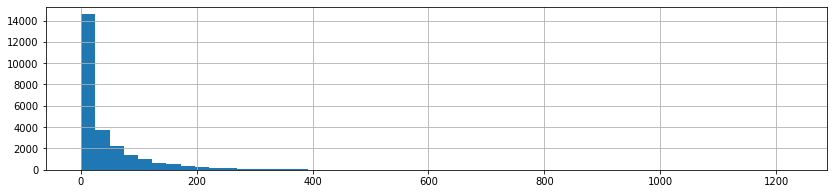

In [374]:
# И сколько постов посмотрел каждый пользователь?
vc = history.value_counts('user_id')
vc.hist(bins=50)

Text(0, 0.5, 'Количество таких пользователей')

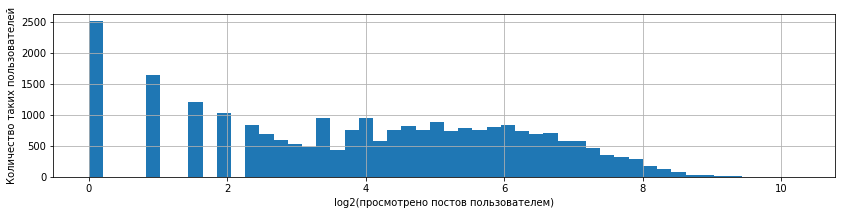

In [375]:
# Логарифмируем
np.log2(vc).hist(bins=50)
plt.xlabel('log2(просмотрено постов пользователем)')
plt.ylabel('Количество таких пользователей')

#### Об результате рекламных компаний

In [376]:
posts = pd.read_csv('data/raw/ads.csv')
posts.head(7)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",3
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4
5,141.0,1288,1322,"3,8,11,15",856,"111,217,235,247,292,340,398,540,541,546,581,61...",5
6,250.0,1198,1451,"1,3,7,10,13,18",336,"24,43,96,124,150,256,299,313,430,450,552,557,5...",6


<AxesSubplot:>

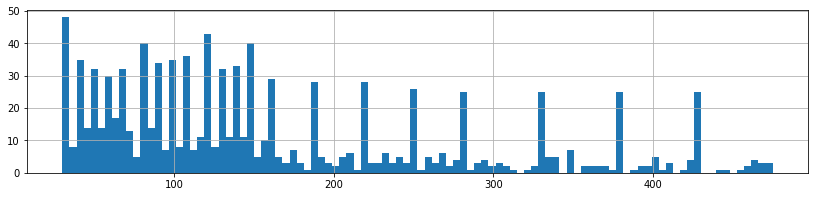

In [377]:
# Сколько по итогам аукциона стоит объявление
posts.cpm.hist(bins=100)

<AxesSubplot:>

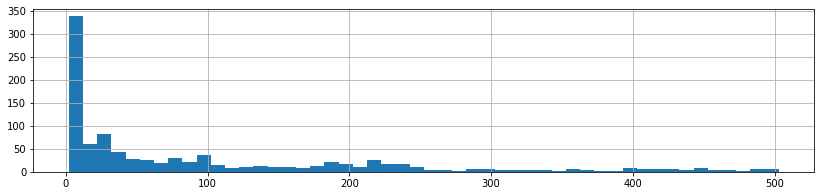

In [378]:
# Сколько часов длится рекламная компания

duration = (posts.hour_end - posts.hour_start)
duration.hist(bins=50)

Text(0, 0.5, 'количество объявлений')

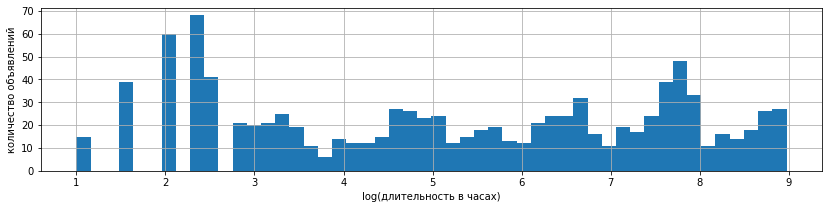

In [379]:
np.log2(duration).hist(bins=50)
plt.xlabel('log(длительность в часах)')
plt.ylabel('количество объявлений')

<AxesSubplot:>

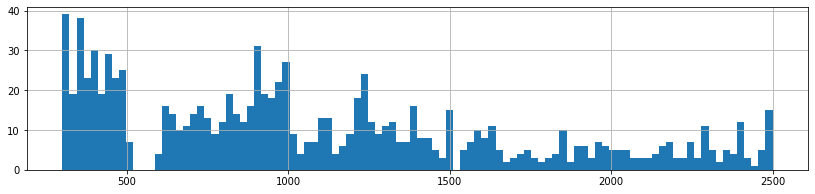

In [380]:
# На какую аудиторию крутилось объявление

posts.audience_size.hist(bins=100)

#### Об охвате

In [381]:
answers = pd.read_csv('data/raw/target.csv')
answers.head(7)

,ad_id,at_least_one
0,0,0.0430
1,1,0.0130
2,2,0.0878
3,3,0.2295
4,4,0.3963
5,5,0.0187
6,6,0.3839


<AxesSubplot:>

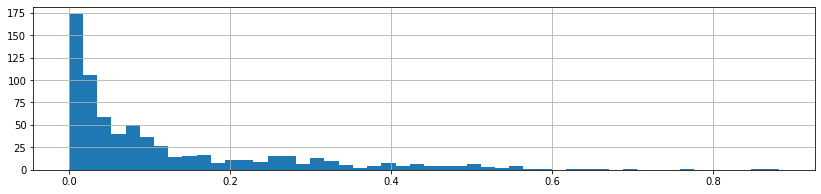

In [382]:
# Какая часть аудитории увидело объявление хоть раз
answers.at_least_one.hist(bins=50)

Если у вас нет непонимания и вопросов о данных, то вы посмотрели хороший анализ данных. Возможно выше неплохой анализ

### Построим модель

#### Выделим числовые признаки

In [383]:
import seaborn as sns

In [384]:
# Соберём простую информацию по каждому объявлению в датасет

# Добавим номер объявления
posts = posts.assign(id=posts.index)
answers = answers.assign(id=answers.index)


ads = pd.merge(posts, answers, on='id')
ads.head(3)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id_x,id,ad_id_y,at_least_one
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0,0,0,0.0430
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1,1,1,0.0130
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2,2,2,0.0878


In [385]:
# Добавим пару простых признаков

ads = ads.assign(n_publishers=ads.publishers.apply(lambda s: len(s.split(','))),
                 duration=ads.hour_end - ads.hour_start)

useful_columns = [
 'cpm',
 'duration',
 'n_publishers',
 'audience_size',
 'at_least_one'
]

ads = ads[useful_columns]
ads.head(5)

,cpm,duration,n_publishers,audience_size,at_least_one
0,220.0,95,2,1906,0.0430
1,312.0,6,2,1380,0.0130
2,70.0,20,6,888,0.0878
3,240.0,82,2,440,0.2295
4,262.0,238,4,1476,0.3963


In [386]:
ads.head(10)

,cpm,duration,n_publishers,audience_size,at_least_one
0,220.0,95,2,1906,0.0430
1,312.0,6,2,1380,0.0130
2,70.0,20,6,888,0.0878
3,240.0,82,2,440,0.2295
4,262.0,238,4,1476,0.3963
5,141.0,34,4,856,0.0187
6,250.0,253,6,336,0.3839
7,280.0,41,3,616,0.3198
8,270.0,16,2,484,0.0062
9,250.0,2,2,972,0.0082


In [387]:
def heatmap(data: pd.DataFrame):
    plt.figure(figsize=(10, 9))
    sns.heatmap(data.corr(), square=True, linecolor='white', annot=True)
    plt.yticks(rotation=30)
    plt.xticks(rotation=30)
    plt.show()

<Figure size 720x648 with 0 Axes>

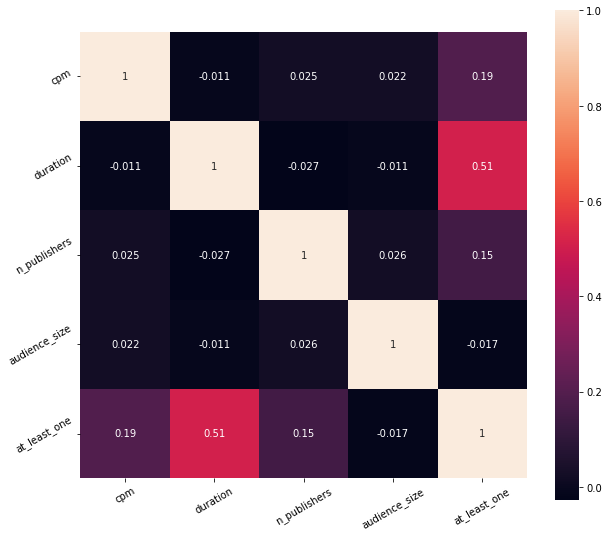

In [388]:
plt.figure(figsize=(10, 9))
heatmap(ads)

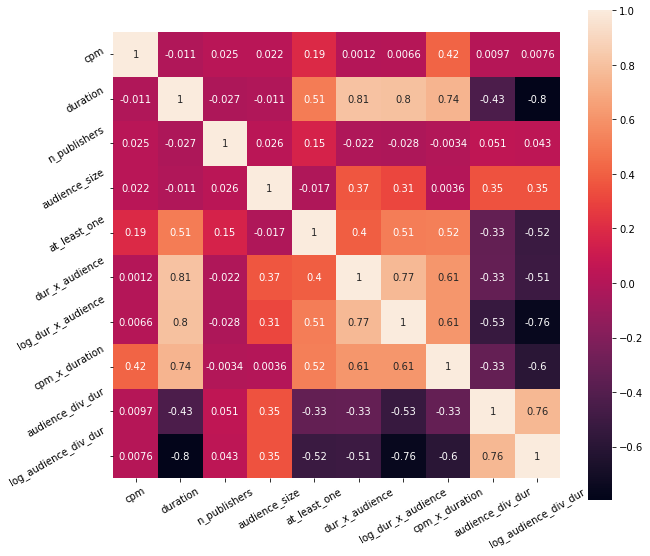

In [389]:
# Добавим дата саенс
ads_featured = ads.assign(
    dur_x_audience=ads.duration*ads.audience_size,
    log_dur_x_audience=np.log(ads.duration*ads.audience_size),
    cpm_x_duration=ads.cpm*ads.duration,
    audience_div_dur = ads.audience_size / ads.duration,
    log_audience_div_dur = np.log(ads.audience_size / ads.duration)
)
heatmap(ads_featured)

#### Обучим линейную регрессию

In [390]:
from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [391]:
def make_xy(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    x = data.drop('at_least_one', axis=1)
    y = data['at_least_one']
    return x, y

In [392]:
def mape(pred: np.ndarray, trueth: np.ndarray) -> np.ndarray:
    # mean_absolute_percentage_error with clipping huge values
    err = np.array(abs(pred - trueth) / trueth)
    err[err > 20] = 20 # clip 2000% error
    return err

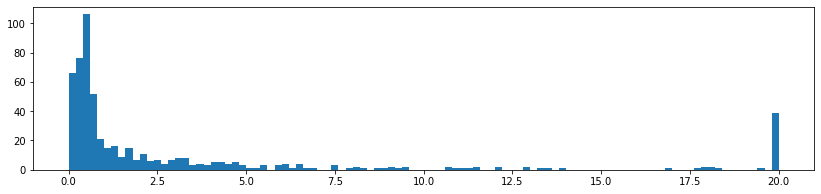

Ошибка на train: 3.2563692659802954
Ошибка на test: 3.386241279386544


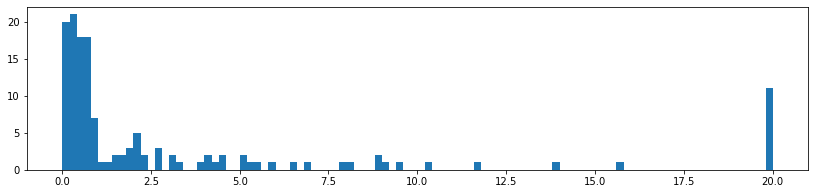

In [393]:
train, test = train_test_split(ads, 
                               test_size=0.2, 
                               random_state=42)
# train, test = train_test_split(ads.assign(
#                                           dur_x_audience=ads.duration*ads.audience_size,
#                                           log_dur_x_audience=np.log(ads.duration*ads.audience_size),
#                                           cpm_x_duration=ads.cpm*ads.duration
#                                          ),
#                                test_size=0.2, 
#                                random_state=42)

# Обучим модель
x, y = make_xy(train)
model = LinearRegression().fit(x, y)

# Оценим ошибку
errors = mape(model.predict(x), y)
plt.hist(errors, bins=100)
plt.show()
print('Ошибка на train:', (errors).mean())

# Оценим ошибку на тесте
x, y = make_xy(test)
errors = mape(model.predict(x), y)
plt.hist(errors, bins=100)
print('Ошибка на test:', (errors).mean())

### Насколько вообще разделимы данные?

In [394]:
import umap.umap_ as umap

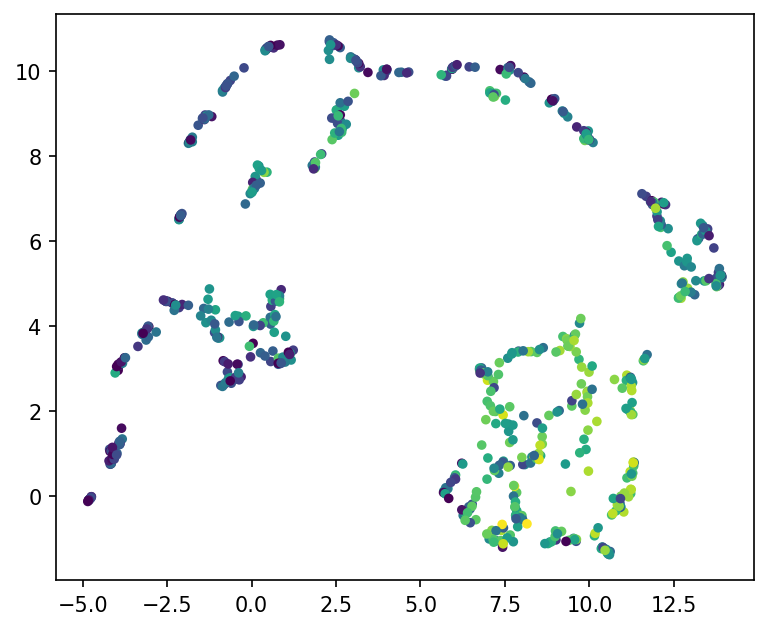

In [395]:
# Покажем похожие объявления точками, а охват цветом
embedding = umap.UMAP().fit_transform(ads[['cpm', 'duration', 'n_publishers']])

plt.figure(figsize=(6, 5), dpi=150)

color = np.log1p(ads.at_least_one * 100)
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color)

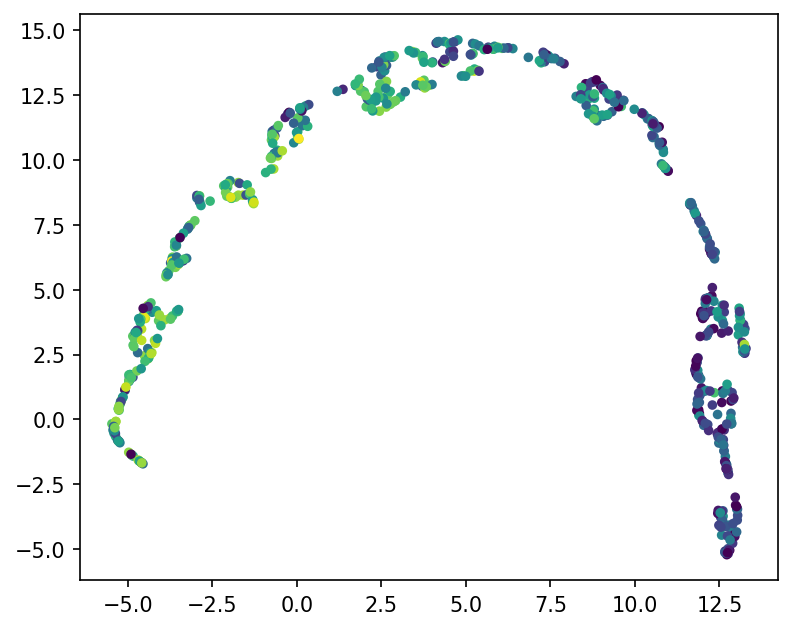

In [396]:
# Покажем похожие объявления точками, а охват цветом. Но на данных с доп фичами
embedding = umap.UMAP().fit_transform(ads_featured[['cpm', 'duration', 'n_publishers', 'dur_x_audience', 'log_dur_x_audience', 'cpm_x_duration']])

plt.figure(figsize=(6, 5), dpi=150)

color = np.log1p(ads.at_least_one * 100)
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color)

In [397]:
def most_viewed_hours(l, r):
    full_day = max(0, (r - r % 24) - (l - l % 24) + 1) * (22 - 8)
    part_day = min(14, max(0, 22 - l % 24)) + min(14, max(0, r % 24 - 8))
    return full_day + part_day

hours = []
for i in range(posts.shape[0]):
    hours.append(most_viewed_hours(posts.hour_start[i], posts.hour_end[i]))
posts['most_viewed_hours'] = hours

In [398]:
posts['user_list'] = posts.user_ids.apply(lambda s: list(map(int, s.split(','))))

In [399]:
sex_mean = []; mean_age = []; std_age = []; min_age = []; max_age = []; city_cnt = []; big_city = []
big_cities = [0, 3, 7]
for lst in posts.user_list:
    cur_users = users[users.user_id.isin(lst)]
    ages = cur_users[cur_users.age > 0].age
    sex_mean.append(cur_users.sex.mean())
    mean_age.append(ages.mean())
    std_age.append(ages.std())
    max_age.append(ages.max())
    min_age.append(ages.min())
    city_cnt.append(cur_users.city_id.nunique())
    big_city.append(cur_users[cur_users.city_id.isin(big_cities)].shape[0])

posts['sex_mean'] = pd.Series(sex_mean)
posts['mean_age'] = pd.Series(mean_age).fillna(0)
posts['std_age'] = pd.Series(std_age).fillna(0)
posts['min_age'] = pd.Series(min_age).fillna(0)
posts['max_age'] = pd.Series(max_age).fillna(0)
posts['big_city'] = pd.Series(big_city).fillna(0)
posts['city_cnt'] = pd.Series(city_cnt)

In [400]:
posts.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id,id,most_viewed_hours,user_list,sex_mean,mean_age,std_age,min_age,max_age,big_city,city_cnt
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0,0,1372,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",1.462225,30.685538,15.174080,13.0,118.0,0,7
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1,1,350,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",1.467391,30.048706,16.638097,13.0,118.0,507,372
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2,2,364,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",1.467342,31.388078,15.861505,13.0,117.0,361,280
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",3,3,1359,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",1.454545,29.867971,14.586025,13.0,117.0,0,7
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4,4,3388,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",1.386856,44.760840,2.806116,41.0,50.0,589,416


In [401]:
ads = pd.merge(posts, answers, on='id')
ads.head(3)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id_x,id,most_viewed_hours,user_list,sex_mean,mean_age,std_age,min_age,max_age,big_city,city_cnt,ad_id_y,at_least_one
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0,0,1372,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",1.462225,30.685538,15.174080,13.0,118.0,0,7,0,0.0430
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1,1,350,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",1.467391,30.048706,16.638097,13.0,118.0,507,372,1,0.0130
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2,2,364,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",1.467342,31.388078,15.861505,13.0,117.0,361,280,2,0.0878


In [402]:
# Добавим пару простых признаков

ads = ads.assign(n_publishers=ads.publishers.apply(lambda s: len(s.split(','))),
                 duration=ads.hour_end - ads.hour_start)

ads = ads.drop(['publishers', 'hour_start', 'hour_end', 'user_ids', 'ad_id_x', 'id', 'user_list', 'ad_id_y'], axis=1)

ads.head(5)

,cpm,audience_size,most_viewed_hours,sex_mean,mean_age,std_age,min_age,max_age,big_city,city_cnt,at_least_one,n_publishers,duration
0,220.0,1906,1372,1.462225,30.685538,15.174080,13.0,118.0,0,7,0.0430,2,95
1,312.0,1380,350,1.467391,30.048706,16.638097,13.0,118.0,507,372,0.0130,2,6
2,70.0,888,364,1.467342,31.388078,15.861505,13.0,117.0,361,280,0.0878,6,20
3,240.0,440,1359,1.454545,29.867971,14.586025,13.0,117.0,0,7,0.2295,2,82
4,262.0,1476,3388,1.386856,44.760840,2.806116,41.0,50.0,589,416,0.3963,4,238


In [403]:
def heatmap(data: pd.DataFrame):
    #plt.figure(figsize=(15, 15))
    sns.heatmap(data.corr(), square=True, linecolor='white', annot=True)
    plt.yticks(rotation=30)
    plt.xticks(rotation=30)
    plt.show()

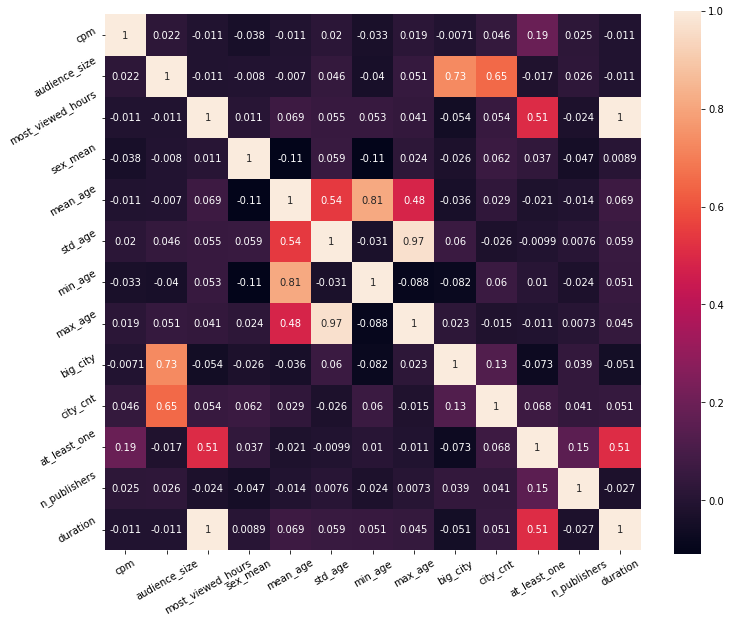

In [404]:
plt.figure(figsize=(12, 10))
heatmap(ads)

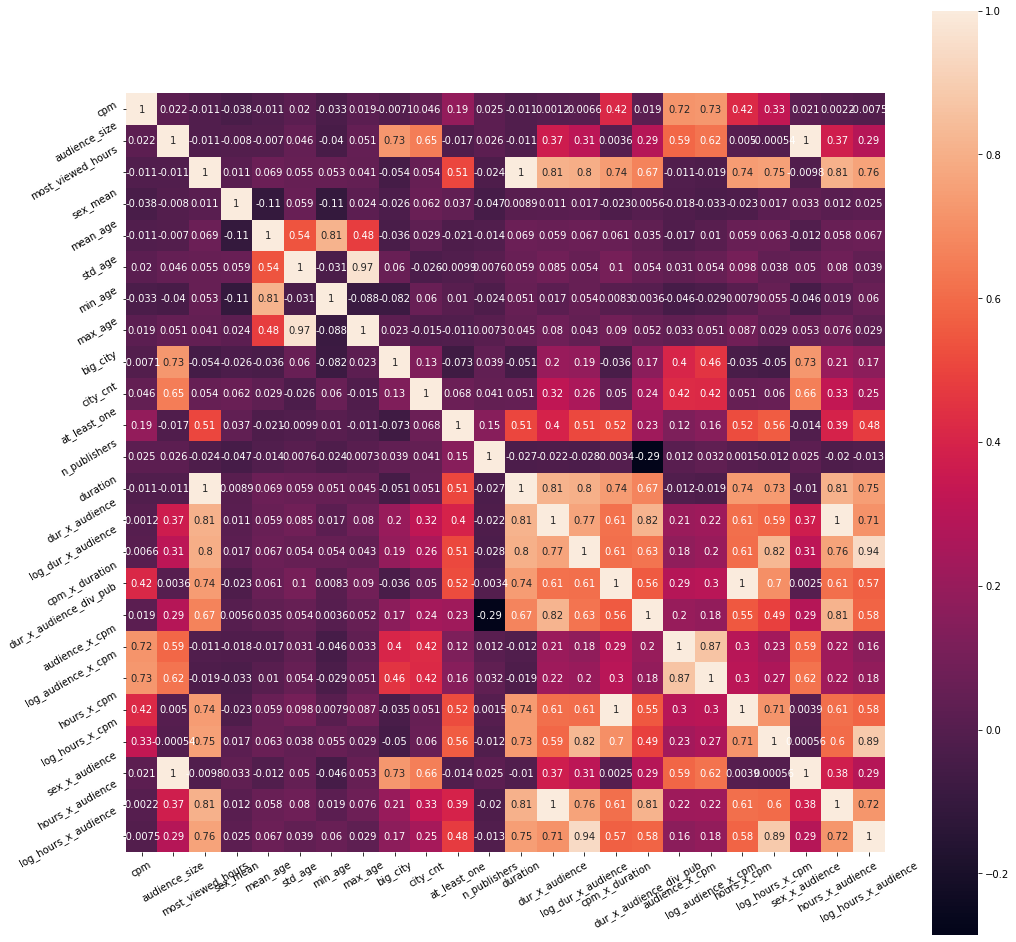

In [405]:
# Добавим дата саенс
ads_featured = ads.assign(
    dur_x_audience = ads.duration * ads.audience_size,
    log_dur_x_audience = np.log(ads.duration * ads.audience_size),
    cpm_x_duration = ads.cpm * ads.duration,
    
    dur_x_audience_div_pub = ads.duration * ads.audience_size / ads.n_publishers,
    audience_x_cpm = ads.cpm * ads.audience_size,
    log_audience_x_cpm = np.log(ads.cpm * ads.audience_size),
    hours_x_cpm = ads.most_viewed_hours * ads.cpm,
    log_hours_x_cpm = np.log(ads.most_viewed_hours * ads.cpm),
    sex_x_audience = ads.sex_mean * ads.audience_size,
    hours_x_audience = ads.most_viewed_hours * ads.audience_size,
    log_hours_x_audience = np.log(ads.most_viewed_hours * ads.audience_size)
)
plt.figure(figsize=(17, 17))
heatmap(ads_featured)

In [406]:
from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [407]:
def mape(pred: np.ndarray, trueth: np.ndarray) -> np.ndarray:
    # mean_absolute_percentage_error with clipping huge values
    err = np.array(abs(pred - trueth) / trueth)
    err[err > 20] = 20  # clip 2000% error
    return err

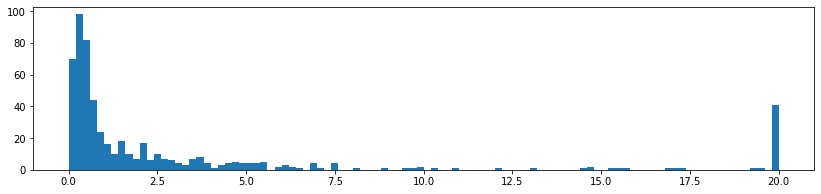

Ошибка на train: 3.1841476874236307
Ошибка на test: 3.4735685897678414


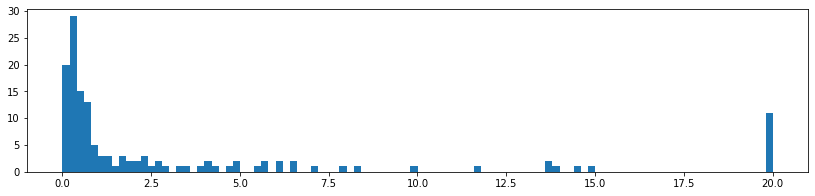

In [408]:
train, test = train_test_split(ads_featured, 
                               test_size=0.2, 
                               random_state=42)

# Обучим модель
x, y = make_xy(train)
model = LinearRegression().fit(x, y)

# Оценим ошибку
errors = mape(model.predict(x), y)
plt.hist(errors, bins=100)
plt.show()
print('Ошибка на train:', (errors).mean())

# Оценим ошибку на тесте
x, y = make_xy(test)
errors = mape(model.predict(x), y)
plt.hist(errors, bins=100)
print('Ошибка на test:', (errors).mean())

Learning rate set to 0.037359
0:	learn: 0.1426225	total: 20.2ms	remaining: 20.2s
1:	learn: 0.1407399	total: 22.8ms	remaining: 11.4s
2:	learn: 0.1389412	total: 25.3ms	remaining: 8.41s
3:	learn: 0.1371108	total: 27.7ms	remaining: 6.9s
4:	learn: 0.1354420	total: 30.7ms	remaining: 6.12s
5:	learn: 0.1338265	total: 33.2ms	remaining: 5.5s
6:	learn: 0.1322129	total: 35.8ms	remaining: 5.08s
7:	learn: 0.1305654	total: 38ms	remaining: 4.71s
8:	learn: 0.1292017	total: 40.6ms	remaining: 4.47s
9:	learn: 0.1278724	total: 42.8ms	remaining: 4.24s
10:	learn: 0.1265307	total: 44.9ms	remaining: 4.04s
11:	learn: 0.1253599	total: 48.9ms	remaining: 4.03s
12:	learn: 0.1241754	total: 51.2ms	remaining: 3.88s
13:	learn: 0.1229917	total: 54ms	remaining: 3.8s
14:	learn: 0.1220610	total: 56.2ms	remaining: 3.69s
15:	learn: 0.1209373	total: 58.5ms	remaining: 3.6s
16:	learn: 0.1198658	total: 62ms	remaining: 3.58s
17:	learn: 0.1188586	total: 64.2ms	remaining: 3.5s
18:	learn: 0.1178947	total: 66.5ms	remaining: 3.43s
19:

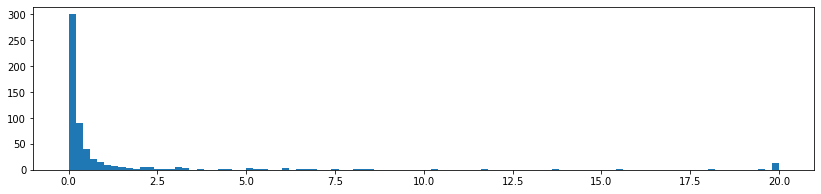

Ошибка на test: 3.088489997351435


(array([24., 24., 14., 15.,  9.,  3.,  1.,  2.,  4.,  2.,  2.,  1.,  2.,
         2.,  5.,  1.,  2.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.]),
 array([8.31821800e-04, 2.00823504e-01, 4.00815185e-01, 6.00806867e-01,
        8.00798549e-01, 1.00079023e+00, 1.20078191e+00, 1.40077359e+00,
        1.60076528e+00, 1.80075696e+00, 2.00074864e+00, 2.20074032e+00,
        2.40073200e+00, 2.60072368e+00, 2.80071537e+00, 3.00070705e+00,
        3.20069873e+00, 3.40069041e+00, 3.60068209e+00, 3.80067378e+00,
        4.00066546e+00, 4.20065714e+00, 4.40064882e+00, 4.60064050e+00,
  

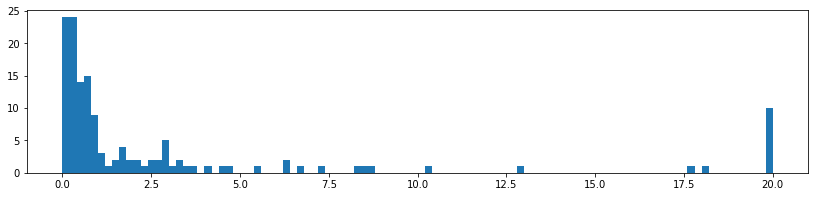

In [409]:
from catboost import CatBoostRegressor
train, test = train_test_split(ads_featured, test_size=0.2,  random_state=42)

# Обучим модель
x_train, y_train = make_xy(train)
cat_model = CatBoostRegressor(random_state=42).fit(x_train, y_train)

# Оценим ошибку
errors = mape(cat_model.predict(x_train), y_train)
print('Ошибка на train:', (errors).mean())
plt.hist(errors, bins=100)
plt.show()

# Оценим ошибку на тесте
x_test, y_test = make_xy(test)
errors = mape(cat_model.predict(x_test), y_test)
print('Ошибка на test:', (errors).mean())
plt.hist(errors, bins=100)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:193: LinAlgWarning: Ill-conditioned matrix (rcond=1.8915e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Ошибка на train: 3.2945135470620075


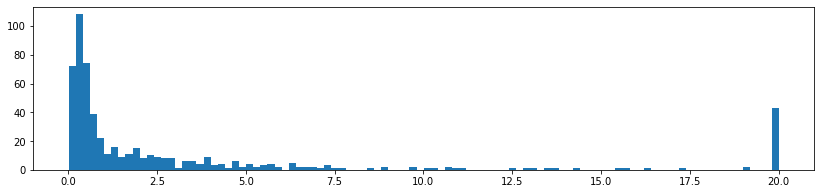

Ошибка на test: 3.483700836121881


(array([25., 23., 12., 12.,  8.,  3.,  1.,  7.,  2.,  2.,  0.,  1.,  3.,
         2.,  1.,  1.,  1.,  1.,  1.,  0.,  3.,  2.,  0.,  0.,  1.,  1.,
         0.,  0.,  2.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,
         0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.]),
 array([7.45485946e-03, 2.07380311e-01, 4.07305762e-01, 6.07231214e-01,
        8.07156665e-01, 1.00708212e+00, 1.20700757e+00, 1.40693302e+00,
        1.60685847e+00, 1.80678392e+00, 2.00670937e+00, 2.20663482e+00,
        2.40656028e+00, 2.60648573e+00, 2.80641118e+00, 3.00633663e+00,
        3.20626208e+00, 3.40618753e+00, 3.60611298e+00, 3.80603844e+00,
        4.00596389e+00, 4.20588934e+00, 4.40581479e+00, 4.60574024e+00,
  

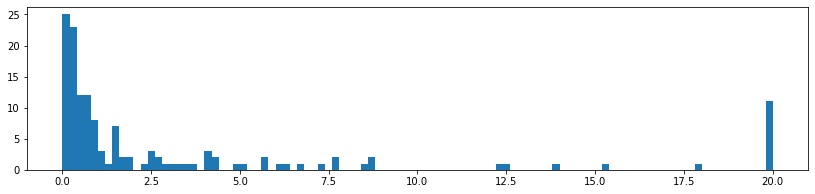

In [410]:
from sklearn.kernel_ridge import KernelRidge

train, test = train_test_split(ads_featured, test_size=0.2,  random_state=42)

x_train, y_train = make_xy(train)

krr_model = KernelRidge()
krr_model.fit(x_train, y_train)

# Оценим ошибку
errors = mape(krr_model.predict(x_train), y_train)
print('Ошибка на train:', (errors).mean())
plt.hist(errors, bins=100)
plt.show()

# Оценим ошибку на тесте
x_test, y_test = make_xy(test)
errors = mape(krr_model.predict(x_test), y_test)
print('Ошибка на test:', (errors).mean())
plt.hist(errors, bins=100)

Ошибка на train: 1.5132599820518966


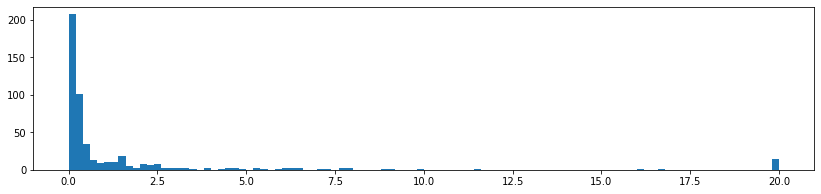

Ошибка на test: 3.2963963481357546


(array([26., 41., 35., 13., 11.,  4.,  3.,  3.,  7.,  4.,  2.,  3.,  2.,
         2.,  3.,  4.,  1.,  0.,  2.,  2.,  0.,  2.,  2.,  0.,  0.,  2.,
         0.,  0.,  0.,  2.,  1.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 16.]),
 array([ 0.02211864,  0.22189746,  0.42167627,  0.62145508,  0.8212339 ,
         1.02101271,  1.22079153,  1.42057034,  1.62034915,  1.82012797,
         2.01990678,  2.21968559,  2.41946441,  2.61924322,  2.81902203,
         3.01880085,  3.21857966,  3.41835847,  3.61813729,  3.8179161 ,
         4.01769492,  4.21747373,  4.41725254,  4.61703136,  4.81681017,
         5.01658898,  5.2163678 ,  5.41614661,  5.61592542,  5.815704

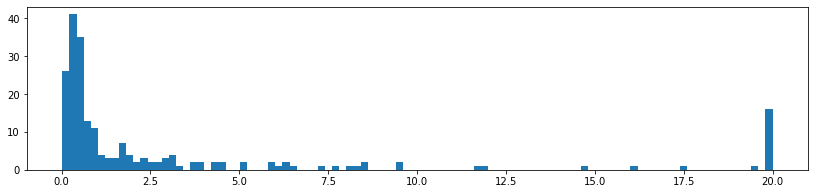

In [411]:
from sklearn.ensemble import RandomForestRegressor

train, test = train_test_split(ads_featured, test_size=0.3,  random_state=42)

x_train, y_train = make_xy(train)

forest_model = RandomForestRegressor(n_estimators = 300, max_features ='auto', random_state = 42)
forest_model.fit(x_train, y_train)

# Оценим ошибку
errors = mape(forest_model.predict(x_train), y_train)
print('Ошибка на train:', (errors).mean())
plt.hist(errors, bins=100)
plt.show()

# Оценим ошибку на тесте
x_test, y_test = make_xy(test)
errors = mape(forest_model.predict(x_test), y_test)
print('Ошибка на test:', (errors).mean())
plt.hist(errors, bins=100)

In [412]:
result = pd.read_csv('data/raw/sample_solution.csv')
ads = pd.merge(posts, result, on='ad_id')
ads.tail(3)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id,id,most_viewed_hours,user_list,sex_mean,mean_age,std_age,min_age,max_age,big_city,city_cnt,at_least_one
305,122.0,1058,1063,"2,5",704,"1,23,29,104,136,176,201,206,250,269,355,403,44...",1005,1005,28,"[1, 23, 29, 104, 136, 176, 201, 206, 250, 269,...",1.482955,30.184170,17.616975,13.0,118.0,278,227,0.118536
306,138.0,932,1169,"1,2,7",1210,"67,73,80,146,182,202,212,254,307,377,383,385,3...",1006,1006,3385,"[67, 73, 80, 146, 182, 202, 212, 254, 307, 377...",1.471901,88.629752,23.329554,60.0,118.0,550,347,0.118536
307,35.0,747,806,"1,3,7,18",1000,"39,78,101,205,242,266,277,284,306,440,447,451,...",1007,1007,706,"[39, 78, 101, 205, 242, 266, 277, 284, 306, 44...",1.479000,31.111232,16.081148,13.0,118.0,407,311,0.118536


In [413]:
ads = ads.assign(
    n_publishers=ads.publishers.apply(lambda s: len(s.split(','))),
    duration=ads.hour_end - ads.hour_start
)

In [414]:
ads = ads.drop(['publishers', 'hour_start', 'hour_end', 'user_ids', 'id', 'user_list'], axis=1)

In [415]:
ads_featured = ads.assign(
    dur_x_audience = ads.duration * ads.audience_size,
    log_dur_x_audience = np.log(ads.duration * ads.audience_size),
    cpm_x_duration = ads.cpm * ads.duration,
    
    dur_x_audience_div_pub = ads.duration * ads.audience_size / ads.n_publishers,
    audience_x_cpm = ads.cpm * ads.audience_size,
    log_audience_x_cpm = np.log(ads.cpm * ads.audience_size),
    hours_x_cpm = ads.most_viewed_hours * ads.cpm,
    log_hours_x_cpm = np.log(ads.most_viewed_hours * ads.cpm),
    sex_x_audience = ads.sex_mean * ads.audience_size,
    hours_x_audience = ads.most_viewed_hours * ads.audience_size,
    log_hours_x_audience = np.log(ads.most_viewed_hours * ads.audience_size)
)

In [416]:
ads_featured.head(3)

,cpm,audience_size,ad_id,most_viewed_hours,sex_mean,mean_age,std_age,min_age,max_age,big_city,...,log_dur_x_audience,cpm_x_duration,dur_x_audience_div_pub,audience_x_cpm,log_audience_x_cpm,hours_x_cpm,log_hours_x_cpm,sex_x_audience,hours_x_audience,log_hours_x_audience
0,330.0,344,700,33,1.494186,30.737500,18.015837,13.0,118.0,149,...,7.450080,1650.0,430.000000,113520.0,11.639734,10890.0,9.295600,514.0,11352,9.337149
1,79.0,1960,701,2046,1.491837,31.789791,16.516753,13.0,118.0,1960,...,12.597980,11929.0,98653.333333,154840.0,11.950148,161634.0,11.993090,2924.0,4010160,15.204342
2,130.0,2400,702,33,1.463333,30.912320,16.227104,13.0,118.0,1039,...,9.392662,650.0,4000.000000,312000.0,12.650758,4290.0,8.364042,3512.0,79200,11.279732


In [417]:
ads_featured = ads_featured.drop(['ad_id'], axis=1)

<AxesSubplot:>

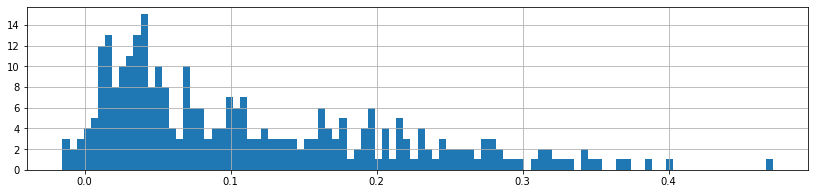

In [418]:
x, y = make_xy(ads_featured)
result.at_least_one = cat_model.predict(x)
result.at_least_one.hist(bins = 100)

In [419]:
result.at_least_one = result.at_least_one.apply(lambda x: max(0, x))

In [420]:
result.to_csv('result.csv', index=False)